# Dependencies


In [2]:
%%capture
pip install --upgrade git+https://github.com/meichenfang/velocyto.py.git

In [3]:
%%capture
pip install scanpy

In [1]:
%%capture
pip install umap-learn

In [ ]:
from urllib.request import urlretrieve
urlretrieve("http://pklab.med.harvard.edu/velocyto/hgForebrainGlut/hgForebrainGlut.loom", "hgForebrainGlut.loom")

('hgForebrainGlut.loom', <http.client.HTTPMessage at 0x7fc1690a1750>)

# vis.py

In [4]:
#For vlm need to save linear/non-linear pca,t-SNE,UMAP,  and true pseudotime/gamma, cluster labels

#!git clone https://github.com/pachterlab/GFCP_2021.git
#!cd GFCP_2021
#import vis 
#vis.makeEmbeds()....

import matplotlib.pyplot as plt
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import velocyto as vcy
import anndata as ad


# parameter
vermeer_hex = ("#A65141", "#E7CDC2", "#80A0C7", "#394165", "#FCF9F0", "#B1934A",
             "#DCA258", "#100F14", "#8B9DAF", "#EEDA9D")
vermeer = [(tuple(int(h.lstrip('#')[i:i+2], 16)/255 for i in (0, 2, 4))) for h in vermeer_hex] 
emb_dict={"default":'pcs',"PCA":"ps", "UMAP":"us", "tSNE":"ts"}
    

def makeEmbeds(vlm, embeds, x_name="S_norm",):
    '''
    Save embedding objects in embeds lists in vlm
    
    Parameters
    ----------
    vlm : Velocyto loompy object
    x_name: X for embedding, e.g. "S", "S_norm"
    embeds : set of embeddings e.g. {'PCA','UMAP','tSNE'}
    
    Returns
    -------
    '''
    
    X = getattr(vlm, x_name) # X=(n_samples, n_features)   
    vlm.PCA = PCA(n_components=50).fit_transform(X.T)
    
    if "PCA" in embeds:
        vlm.ps = np.array(vlm.PCA[:,:2], order="C")
        
    if 'UMAP' in embeds:
        vlm.us = umap.UMAP(n_components=2).fit_transform(vlm.PCA[:, :25])
        
    if 'tSNE' in embeds:
        vlm.ts = TSNE(n_components=2).fit_transform(vlm.PCA[:, :25]) 

    if "default" in embeds:
        vlm.perform_PCA(which=x_name)

    return 

def preprocess(vlm,nGene=1000,filter=True):
    if filter:
        vlm.filter_cells(bool_array=vlm.initial_Ucell_size > np.percentile(vlm.initial_Ucell_size, 0.5))
        vlm.score_detection_levels(min_expr_counts=40, min_cells_express=30)
        vlm.filter_genes(by_detection_levels=True)
        vlm.score_cv_vs_mean(N=nGene, plot=False, max_expr_avg=35)
        vlm.filter_genes(by_cv_vs_mean=True)

    vlm.normalize("both", size=True, log=True)
    vlm.perform_PCA(which="S_norm")
    return

def getImputed(vlm, knn_k=50):
    '''
    Get gamma inference from imputed counts
    
    Parameters
    ----------
    
    Returns
    -------
    '''

    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
    vlm.knn_imputation(n_pca_dims=n_comps,k=knn_k, balanced=True, b_sight=np.minimum(knn_k*8, vlm.S.shape[1]-1), b_maxl=np.minimum(knn_k*4, vlm.S.shape[1]-1))
    vlm.normalize("imputed", size=True, log=True)

    #Get gamma inference
    vlm.fit_gammas(use_imputed_data=True, use_size_norm=True, \
               weighted=True, weights="maxmin_diag", \
               maxmin_perc=[2,95], limit_gamma=True)
    delta_t = 1
    vlm.used_delta_t = delta_t
    velocity = vlm.Ux_sz - vlm.gammas[:,None] * vlm.Sx_sz # same as vlm.predict_U() and vlm.calculate_velocity()
    vlm.delta_S = delta_t * velocity # same as vlm.calculate_shift()
    vlm.Sx_sz_t = vlm.Sx_sz + vlm.delta_S  # same as vlm.extrapolate_cell_at_t(delta_t=1)
    return vlm


def getNeighbors(embed, n_neigh = 150, p=1):
    """Get indices of nearest neighbors in embedding (shape n_samples,n_features)"""
    nbrs = NearestNeighbors(n_neighbors=n_neigh, p=p).fit(embed)
    distances, indices = nbrs.kneighbors(embed)
    return indices

def getJaccard(vlm, embed1, embed2, n_neigh=150):
    '''
    Get jaccard distance between embeddings
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    emb_dict={"PCA":"ps", "UMAP":"us", "tSNE":"ts"}
    x1=getattr(vlm, emb_dict[embed1])
    x2=getattr(vlm, emb_dict[embed2])
    embed1_neighbor = getNeighbors(x1,n_neigh)
    embed2_neighbor = getNeighbors(x2,n_neigh)
    frac = [0]*embed1_neighbor.shape[0]
    for i in range(embed1_neighbor.shape[0]):
        inter = set(embed1_neighbor[i,:]).intersection(embed2_neighbor[i,:])
        frac[i] = len(inter)/len(set(embed1_neighbor[i,:]).union(embed2_neighbor[i,:]))
    return frac

# def princCurveCompute(ax,vlm,meta):
#     '''
#     Plot principal curve coordinates for linear PCA embedding
    
#     Parameters
#     ----------
    
#     Returns
#     -------
#     '''
#     return


# ---------------- Plotting -------------


def princCurvePlots(ax,vlm,meta):
    '''
    Plot principal curve coordinates for linear PCA embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    nCells,nGenes,T,tau,topo = meta
    tvec_red = np.linspace(np.min(vlm.ca['time']),np.max(vlm.ca['time']))
    gamma = vlm.ra['gamma']
    beta = vlm.ra['beta']
    dict_nk = {"aba":2,"ab(a/c)":3,"ab(c/d)":4}
    dict_Kval = {"aba":[0],"ab(a/c)":[0,2],"ab(c/d)":[2,3]}
    n_K = dict_nk[topo]
    
    branches = dict_Kval[topo]
    n_branches = len(branches)
    for i in range(n_branches):
        K = np.vstack([vlm.ra['k'+str(i)] for i in range(n_K)]).T
        Xtheo = [[eval_x(get_cell_spec_K(K[j],branches[i]),tau,t,beta[j],gamma[j]) for t in tvec_red] for j in range(nGenes)]
        Xtheo = np.asarray(Xtheo)
        Xtheo[np.isnan(Xtheo)]=0
        Xtheo[np.isinf(Xtheo)]=0
        Xtheo = np.swapaxes(Xtheo,0,2)

        # print(got)
        Y = vlm.pca.transform(Xtheo[1,:,:])
        ax.plot(Y[:,0],Y[:,1],c='k')

    # princCurveCompute(ax,vlm,meta)
    return

def plotJaccard(ax,vlm,pair,n_neigh):
    '''
    Single jaccard distance plot
    
    Parameters
    ----------
    ax: plot axis
    vlm: velocyto 
    Returns
    -------
    '''
    frac=getJaccard(vlm, pair[0], pair[1],n_neigh)
    ax.hist(frac)
    ax.set_title('Jaccard distances for neighbors between ' + pair[0] + ' and '  + pair[1])
    return

def jaccardPlots(vlm,pairs,n_neigh):
    '''
    Plot jaccard distances for neighbors between pairs of embeddings
    
    Parameters
    ----------
    vlm: VelocytoLoom instance
    pairs: tuple of two element tuples, e.g (('ps','ts'),('ts','us'))
    n_neigh: number of neighbors

    Returns
    -------
    fig: figure
    
    '''
    emb_set=set(emb for pair in pairs for emb in pair)
    for emb in emb_set:
        if emb not in ("PCA","UMAP",'tSNE'):
            raise NameError('only support PCA, UMAP and tSNE')
    makeEmbeds(vlm, emb_set,x_name='Sx_sz')

    n=len(pairs)
    fig, ax = plt.subplots(1,n, figsize=(6*n,4))
    if n==1:
        plotJaccard(ax,vlm,pairs[0],n_neigh)
    else:
        for i in range(n):
            plotJaccard(ax[i],vlm, pairs[i],n_neigh)
    return


def plotPhase(ax, vlm, gene_idx):
    '''
    Plot phase portrait
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    y=vlm.Ux_sz[gene_idx,:]
    x=vlm.Sx_sz[gene_idx,:]
    k=vlm.gammas[gene_idx]
    b=vlm.q[gene_idx]
    print(k)
    ax.plot(x, y, 'b.')
    ax.set_xlabel('spliced')
    ax.set_ylabel('unspliced')
    # if k!=0: # not sure I get this
    #     x0=np.minimum(np.amin(x),np.amin((y-b)/k))
    #     x1=np.maximum(np.amax(x),np.amax((y-b)/k))
    # else:
    #     x0=np.min(x)
    #     x1=np.max(x)
    # x_=np.array([x0,x1])
    x_=np.array([np.amin(x), np.amax(x)])
    ax.plot(x_, x_*k+b, 'r')
    return

def plotGammaK(ax, vlm, gene_idx, n_neigh, gamma,sim=False):
    '''
    Plot gamma over k neighbors for gene at gene_idx
    
    Parameters
    ----------
    
    Returns
    -------
    
    '''
    ax.plot(n_neigh, gamma,'k-')
    if sim:
        ax.plot(n_neigh,vlm.ra["gamma"][gene_idx]*np.ones(len(n_neigh)),'r-')
    ax.set_xlabel("k neighbors")
    ax.set_ylabel("gamma")
    return

def phasePlots(vlm,n_neighs,genes,sim=False):
    '''
    Plot phase portrais with gamma distributions for various genes across n_neighs
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    if type(genes) is list or type(genes) is tuple: #looking at SPECIFIC genes enumerated in an iterable
        m = len(genes)
    else: #just some random genes
        m = genes
        genes = np.random.choice(vlm.ra['Gene'],m,replace=False)

    
    n = len(n_neighs)
    gammas = np.zeros((m,n))
    fig, ax = plt.subplots(m,n+1,figsize=((n+1)*6,m*4))
    n_comps = np.where(np.diff(np.diff(np.cumsum(vlm.pca.explained_variance_ratio_))>0.0055))[0][0]
    
    for j, knn_k in enumerate(n_neighs):      
        vlm.knn_imputation(k=knn_k, n_pca_dims=n_comps, balanced=True, 
                           b_sight=np.minimum(knn_k*8, vlm.S.shape[1]-1), 
                           b_maxl=np.minimum(knn_k*4, vlm.S.shape[1]-1))
        
        vlm.normalize("imputed", size=True, log=True)
        
        vlm.fit_gammas(use_imputed_data=True, use_size_norm=True, \
               weighted=True, weights="maxmin_diag", \
               maxmin_perc=[2,95], limit_gamma=True)
        
        #For genes 1...n
        for i, gene in enumerate(genes):
            gene_idx=int(np.where(vlm.ra['Gene']==gene)[0][0])
            plotPhase(ax[i][j], vlm, gene_idx)
            gammas[i,j]=vlm.gammas[gene_idx]

    #Plot inferred gamma + line for upregulate cells
    for i, gene in enumerate(genes):
        gene_idx=np.where(vlm.ra['Gene']==gene)[0][0]
        plotGammaK(ax[i][n], vlm, gene_idx, n_neighs, gammas[i,:],sim=sim)
        # if sim:
            

    return fig


def plotEmbed(ax,vlm,embed,c='gray'):
    '''
    Plot given embedding (UMAP, t-SNE, etc)
    
    Parameters
    ----------
    c: colors

    Returns
    -------
    '''
    x=getattr(vlm, embed)
    ax.scatter(x[:,0],x[:,1],marker=".",c=c)
    return


def plotGrid(ax,vlm,gridx,gridv,trans,c='b'):
    '''
    Plot grid with arrows given embedding
    
    Parameters
    ----------
    
    Returns
    -------
    '''
    x=getattr(vlm, gridx)
    v=getattr(vlm, gridv)
    masks=vlm.total_p_mass>0.01
    ax.quiver(x[masks, 0], x[masks, 1], v[masks, 0], v[masks, 1], color=c, scale=10, label=trans)
    return


def gridArrowPlots(vlm,Trans,embed,sim=False,meta=None):
    '''
    Plot arrow embeddings for vlm data with defined count transformations
    
    Parameters
    ----------
    sim: boolean to look for true pseudotime or cluster and/or principal curve
    
    Returns
    -------
    
    '''
    getImputed(vlm, knn_k=50)
    makeEmbeds(vlm, embeds=embed, x_name='Sx_sz')
    emb=emb_dict[embed]
    fig,ax=plt.subplots(1,1)

    if sim and embed=="PCA":
        princCurvePlots(ax,vlm,meta)

    if sim:
        plotEmbed(ax, vlm, emb, c=vlm.ca["time"])
    else:
        plotEmbed(ax, vlm, emb, c=vlm.ca["Clusters"])

    for i,trans in enumerate(Trans):
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                      n_neighbors=150, knn_random=False, sampled_fraction=1)
        vlm.corrcoef_random[np.isnan(vlm.corrcoef_random)]=1
        vlm.corrcoef[np.isnan(vlm.corrcoef)]=1
            
        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        vlm.calculate_grid_arrows(smooth=0.5, steps=(25, 25), n_neighbors=100)
        
        plotGrid(ax,vlm,"flow_grid","flow",trans,c=vermeer[i])
    plt.legend()




def plotTheta(ax, X, Y):
    '''
    Single angle deviation plot
    '''
    angles=np.sum(X*Y,axis=1)/( np.linalg.norm(X,axis=1) * np.linalg.norm(Y,axis=1) )
    ax.hist(np.arccos(angles),density=True)
    ax.set_xlabel("angle")
    ax.set_ylabel("density")
    return 

def angleDevPlots(vlm,Trans,n_neigh,embed,baseline):
    '''
    Plot angle deviations from transformations over varying neighbors for embedding (only compared to baseline)
    
    Parameters
    ----------

    Returns
    -------
    '''
    getImputed(vlm, knn_k=50)
    makeEmbeds(vlm, embeds=embed, x_name='Sx_sz')
    emb=emb_dict[embed]
    fig, ax= plt.subplots(len(Trans),len(n_neigh),figsize=(len(n_neigh)*6,len(Trans)*4))
 
    for i,trans in enumerate(Trans):
        vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                        n_neighbors=baseline, knn_random=False, sampled_fraction=1)
        vlm.corrcoef_random[np.isnan(vlm.corrcoef_random)]=1
        vlm.corrcoef[np.isnan(vlm.corrcoef)]=1
              
        vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
        baseline_arrow=vlm.delta_embedding
          
        for j, k in enumerate(n_neigh):
            vlm.estimate_transition_prob(hidim="Sx_sz", embed=emb, transform=trans, 
                                          n_neighbors=k, knn_random=False, sampled_fraction=1)
            vlm.corrcoef_random[np.isnan(vlm.corrcoef_random)]=1
            vlm.corrcoef[np.isnan(vlm.corrcoef)]=1
                
            vlm.calculate_embedding_shift(sigma_corr = 0.05, expression_scaling=False)
            
            plotTheta(ax[i,j], baseline_arrow, vlm.delta_embedding)
        
    return


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [5]:

# ---------------- Simulation -------------

def eval_x_interval(k_,dt,beta,gamma,x0):
    '''
    Evaluates a single gene's average expression at a time point dt after
    the system is started. This solution results from the reaction 
    rate equations, and is specifically implemented for a time interval wherein
    the parameter values are constant.
    
    Parameters
    ----------
    k_: transcription rate (constitutive)
    dt: time since system is started
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0
    
    Returns
    -------
    x: average expression value (vector, unspliced and spliced)
    '''
    gamma /= beta
    dt *= beta
    k_ /= beta
    x = np.array([k_*(1-np.exp(-dt)) + x0[0]*np.exp(-dt), 
        np.exp(-dt*gamma) * \
        (np.exp(dt*gamma) * k_ * (gamma-1) + \
        - k_*np.exp(dt*(gamma-1))*gamma \
        + k_\
        + (gamma-1)*gamma*x0[1] \
        +gamma*x0[0]*(np.exp((gamma-1)*dt)-1)) \
        /gamma/(gamma-1)])
    return x
def eval_x(k,tau,t,beta,gamma):
    '''
    Evaluates a single gene's average expression at a time point t. 
    This solution derives from the reaction rate equations. The value is 
    computed by evaluating the RREs piecewise over succeeding intervals 
    until time t is reached. 
    
    Parameters
    ----------
    k: transcription rate (constitutive, given by a vector over "cell types")
    tau: cell type transition times
    t: time of interest
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0 (in this case, we assume it starts with Poisson)
    
    Returns
    -------
    x: average expression value (vector, unspliced and spliced)
    '''
    # x=x0
    x0 = [k[0]/beta, k[0]/gamma]
    x=x0
    ind_last = sum(tau<=t)
    tau = np.concatenate((tau[:(ind_last)],[t]))
    for ind in range(ind_last):
        x = eval_x_interval(k[ind],tau[ind+1]-tau[ind],beta,gamma,x)
    return x

def poiss_samp(k,tau,t,beta,gamma):
    '''
    Simulates a single gene's expression at a time point t. 
    This solution derives from the reaction rate equations. The average 
    expression is computed; then, a Poisson random variable with that 
    expectation is sampled to produce an observation. 
    
    Parameters
    ----------
    k: transcription rate (constitutive, given by a vector over "cell types")
    tau: cell type transition times
    t: time of interest
    beta: splicing rate
    gamma: degradation rate
    x0: average expression at t=0
    
    Returns
    -------
    x: instantaneous expression (vector, unspliced and spliced)
    '''
    x = np.random.poisson(eval_x(k,tau,t,beta,gamma))
    return x

def get_cell_spec_K(K,cell_type):
    k = [K[0],K[1],K[cell_type]]
    return np.array(k)

def simulate_occup_meas(nCells=2000, nGenes=100, T=20, tau = [0,8,13], topo="aba"):
    '''
    Simulates a gene expression given a constitutive model with transient
    dynamics. A vector of observation times is initializated; then, the 
    occupation measures are sampled to produce single-molecule observations
    consistent with canonical RNA velocity models.
    
    Parameters
    ----------
    nCells: number of cells to simulate
    nGenes: number of genes to simulate
    T: process halting time
    tau: process-wide transition times
    topo: string indicating whether the process topology. This defines the 
    transcription rate arrays K over the trajectory.
        "aba": cells are perturbed and return back to the original attractor.
            2 parameters. 
        "ab(a/c)": cells are perturbed; half return and half seek a new attractor.
            3 parameters (one is duplicated).
        "ab(c/d)" cells branch to attractors c and d through b.
            4 parameters.

    Returns
    -------
    X: spliced and unspliced samples from occupation measure
        (array, 2 x nCells x nGenes)
    branch_cells: indices of cells that branch off
    tvec: ground truth pseudotimes
    K: ground truth initiation rates
    g_true: ground truth degradation rates
    b_true: ground truth splicing rates (all 1)
    '''
    #define occupation measure for sampling: df = dt/T
    tvec = np.random.rand(nCells)*T
    #initialize arrays for simulations
    X = np.zeros((2,nCells,nGenes))
    g_true = np.zeros(nGenes)
    b_true = np.zeros(nGenes)
    cell_types = np.zeros(nCells,dtype=int)

    tau = np.array([0,8,13])
    cell_types[tvec<tau[1]] = 0 #a
    cell_types[(tvec>tau[1]) & (tvec<tau[2])] = 1
    if topo == "aba":
        n_K = 2
        cell_types[tvec>tau[2]] = 0
        # print("aba")
    else:
        n_branch_cells = int(nCells/2)
        branch_cells = np.random.choice(nCells,n_branch_cells,False)
        filt = np.zeros(nCells,dtype=bool)
        filt[branch_cells] = True
        if topo == "ab(a/c)":
            n_K = 3
            cell_types[(tvec>tau[2]) & ~filt] = 0
            cell_types[(tvec>tau[2]) & filt] = 2
            print("ab(a/c)")
        if topo == "ab(c/d)":
            n_K = 4
            cell_types[(tvec>tau[2]) & ~filt] = 2
            cell_types[(tvec>tau[2]) & filt] = 3
            print("ab(c/d)")
    # print(cell_types)
    K = np.zeros((nGenes,n_K))


    for j in range(nGenes):
        # print(j)
        FLAG = True
        while FLAG:
            #this defines states a, b, c, d.
            kinit = 10**np.random.normal(1,size=n_K)
            K[j,:] = kinit
            # print(kinit)
            beta = 1 #10**np.random.normal(0,1)
            b_true[j]=beta
            gamma = 10**np.random.normal(0,1)
            g_true[j] = gamma

            try: #the simulation procedure is not necessarily stable. If it
                #produces unreasonable samples, we resample the parameters.
                for i in range(nCells):
                    # print(nCells)
                    # x0 = [kinit[0]/beta, kinit[0]/gamma]
                    X[:,i,j]= poiss_samp(get_cell_spec_K(K[j],cell_types[i]),tau,tvec[i],beta,gamma)
                    # print(i)
                    # if i==0:
                    #     print(K[j,cell_types[i]])
                    #     print(tvec[i])
            except:
                # print(kinit)
                # print(x0)
                # print('big yikes')
                # poiss_samp(get_cell_spec_K(K[j],cell_types[i]),tau,tvec[i],beta,gamma)
                pass
            
            if ~np.any(np.isnan(X[:,:,j])):
                FLAG=False
    return X,cell_types,tvec,K,g_true,b_true

def sim_export(simdata, name="simdata"):
    X,cell_types,tvec,K,g_true,b_true = simdata
    adata=ad.AnnData(np.sum(X,axis=0))
    adata.layers["spliced"] = X[1,:,:]
    adata.layers["unspliced"] = X[0,:,:]
    adata.layers["ambiguous"]=np.zeros((nCells,nGenes))
    # br = np.zeros(nCells,dtype=bool)
    # br[branch_cells]=True
    adata.obs["time"]=tvec
    adata.obs["celltype"]=cell_types
    adata.var["gamma"]=g_true
    adata.var["beta"]=b_true
    adata.var["Gene"]=np.asarray([str(i) for i in range(nGenes)])
    # adata.uns["K"]=K
    n_K = K.shape[1]
    for i in range(n_K):
        adata.var["k"+str(i)]=K[:,i]
    # adata.var["km"]=K[:,1]
    # adata.var["k1"]=K[:,2]
    # adata.var["k2"]=K[:,3]
    adata.uns['tau']=tau
    adata.write_loom(name+".loom")

# Test

In [ ]:
vlm = vcy.VelocytoLoom(loom_filepath="hgForebrainGlut.loom")
preprocess(vlm)

## phasePlots

0.044927027
0.027520904
0.015969316
1.1125202
0.15115692
0.024751278
0.92222184
0.36609936
0.014086742
1.2465428
0.40793645
0.021491254
Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7fc16ea695f0> (for post_execute):


KeyboardInterrupt: ignored

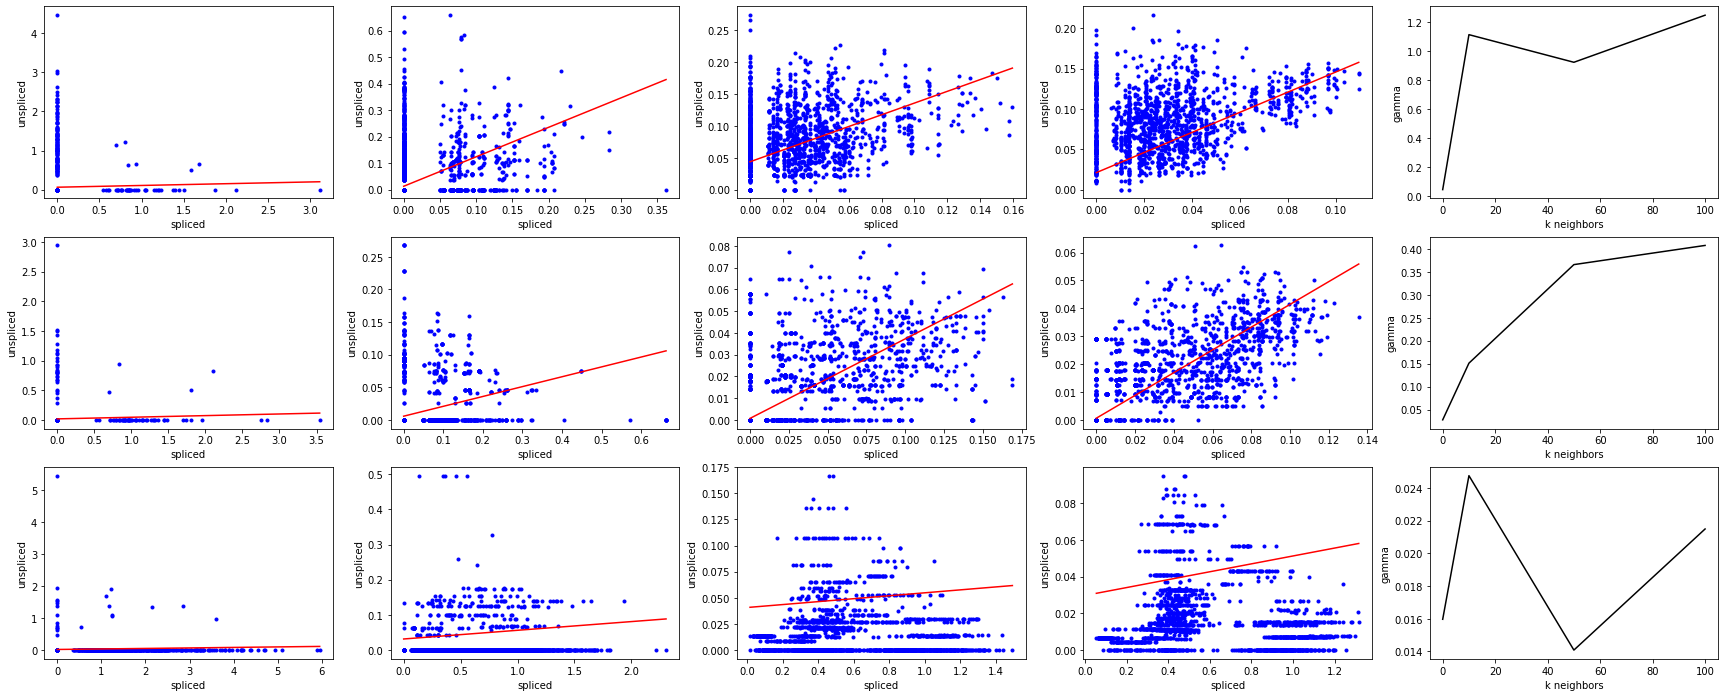

In [ ]:
fig=phasePlots(vlm,n_neighs=[0,10,50,100],genes=3)
# fig=phasePlots(vlm,n_neighs=[0,10,50,100],genes=["DCX","GRIA3"])

## jaccardPlots

In [ ]:
jaccardPlots(vlm,pairs=[["PCA","UMAP"],["PCA","tSNE"]],n_neigh=50)

AttributeError: ignored

Check versioning

## gridArrowPlots

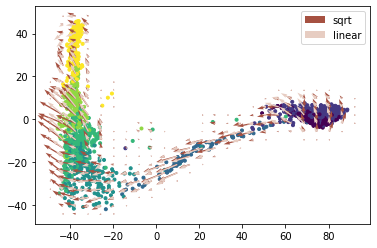

In [ ]:
gridArrowPlots(vlm,Trans=["sqrt","linear"],embed="PCA",sim=False)

## angleDevPlots

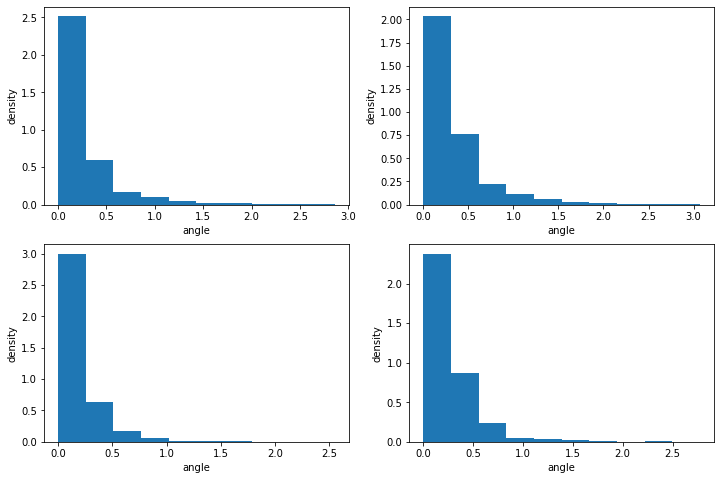

In [ ]:
angleDevPlots(vlm,Trans=["sqrt","linear"],n_neigh=[100,150],embed="PCA",baseline=50)

#Simulation

Generate simulation data

In [6]:
nCells,nGenes,T,tau,topo =  2000,100,20,[0,8,13],"ab(a/c)"
meta = nCells,nGenes,T,tau,topo

In [7]:
simdata = simulate_occup_meas(nCells,nGenes,T,tau,topo)

ab(a/c)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars


In [8]:
sim_export(simdata)

In [9]:
vlm = vcy.VelocytoLoom(loom_filepath="simdata.loom")
preprocess(vlm,filter=False)

0.7526626
0.77106553
22.164192
0.73284155
0.766966
24.065845
0.7431773
0.76872826
24.152187
0.73692966
0.7682658
24.128391


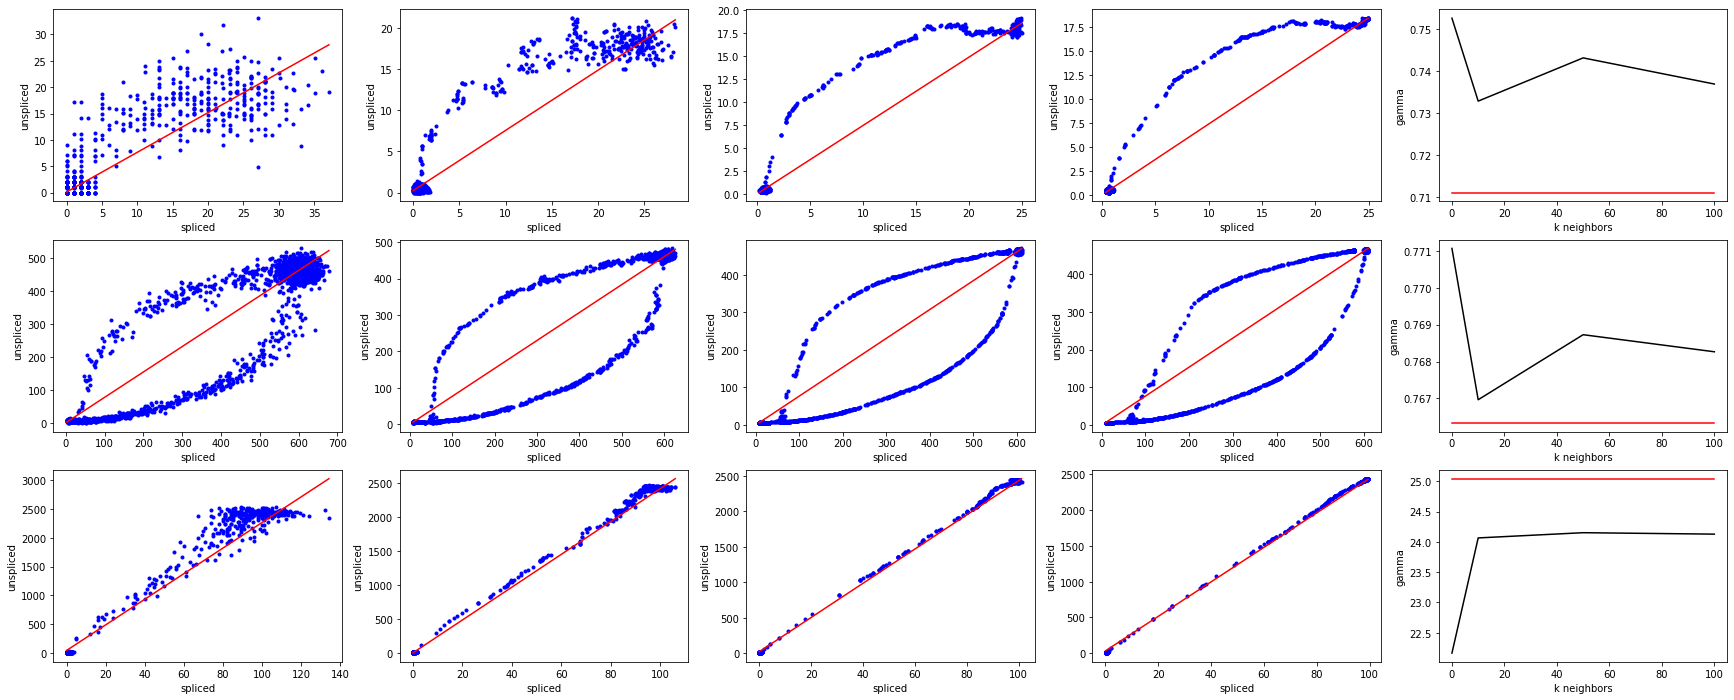

In [10]:
fig=phasePlots(vlm,n_neighs=[0,10,50,100],genes=3,sim=True)


In [11]:
corr = np.corrcoef(vlm.S)

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


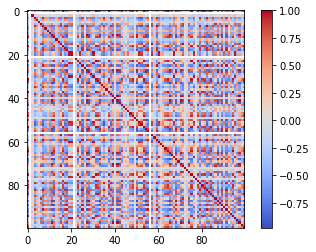

In [15]:
plt.imshow(corr,cmap='coolwarm',interpolation='nearest')
plt.colorbar()

this looks a little weird

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in double_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in double_scalars


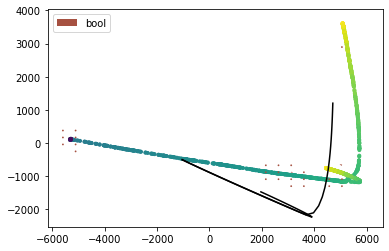

In [ ]:
gridArrowPlots(vlm,Trans=["bool"],embed="PCA",sim=True,meta = meta)

In [ ]:
# vlm.ra['gamma']

array([1.79502797e+00, 4.40066011e-02, 1.81760295e+00, 7.16745653e-01,
       1.96777051e+01, 2.28120263e+00, 5.05928920e-02, 1.31748558e+01,
       5.53571443e+02, 8.27991873e-01, 1.92551792e-01, 2.91187023e+00,
       5.47181569e-01, 2.55842293e+01, 1.11245883e+00, 1.14053548e+02,
       1.21661789e-01, 9.65383439e+00, 3.42274547e-01, 2.80785975e-01,
       5.22330974e+00, 4.90498413e-02, 1.72071724e+01, 1.05898674e+00,
       9.13267576e-01, 4.00405908e-02, 4.15315102e+00, 1.30426358e+03,
       5.20268186e-01, 6.57759082e-02, 1.08539015e+00, 1.10309756e+00,
       1.90436145e-01, 2.46168728e+00, 2.48705097e+02, 5.14404672e+00,
       4.02088777e+00, 3.30051949e+00, 1.56143948e+01, 1.87285420e-01,
       2.50157131e-01, 4.15425501e-01, 1.43953953e+00, 4.86288561e-01,
       2.51754396e-02, 2.42080562e-01, 2.16087036e-02, 1.35645641e-01,
       1.77568016e-01, 2.82024538e+00, 1.00738252e+01, 2.97312686e-02,
       1.30102749e-02, 1.39122046e+01, 1.82443963e+01, 8.57244236e-01,
      